In [3]:
from disan_keras_layers import DISAN
from disan_keras import get_attn, plot_attn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, Reshape
from keras.optimizers import Adadelta
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
import os
%matplotlib inline

In [5]:
df = web.get_data_yahoo('SPY')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,96.341499,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,96.596519,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,96.664566,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,97.072586,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,97.395630,126402800


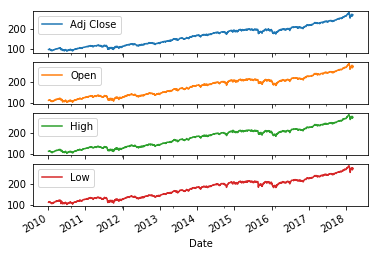

In [6]:
ts = df[['Adj Close', 'Open', 'High', 'Low']].dropna()
ts.plot(subplots=True);

In [7]:
t = 10
train_perc = 0.9

#ts_scaled = MinMaxScaler().fit_transform(ts.values.reshape(-1, 1))[:, 0]
ts_scaled = np.diff(np.log(ts.values + 1), axis=0)
print(ts_scaled.min(), ts_scaled.max(), ts_scaled.shape)

X, y = [], []
for i in range(len(ts_scaled)):
    if i >= t:
        X.append(ts_scaled[i-t:i])
        y.append(ts_scaled[i, 0])
        
X, y = np.asarray(X), np.asarray(y)
train_len = int(len(X) * train_perc)
X_train, y_train = X[:train_len, ...], y[:train_len, ...]
X_test, y_test = X[train_len:, ...], y[train_len:, ...]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
assert not np.isnan(ts_scaled).any() and not np.isnan(ts_scaled).any() and not np.isinf(ts_scaled).any() and not np.isinf(ts_scaled).any()

-0.09847840609974945 0.05095638777688283 (2058, 4)
(1843, 10, 4) (1843,) (205, 10, 4) (205,)


In [8]:
n = 64

ts_input = Input(shape=(t, 4))
#ts_reshape = Reshape((t, 1))(ts_input)

disan = DISAN(n, dropout=0.2)
rep_2d = disan(ts_input)

output = Dense(1, activation='linear')(rep_2d)

model = Model(ts_input, output)
opt = Adadelta(lr=0.5)
model.compile(loss='mse', optimizer=opt, metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 4)             0         
_________________________________________________________________
disan_1 (DISAN)              (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [9]:
filepath = 'models'
callbacks = [
    ReduceLROnPlateau(patience=0, verbose=1),
    EarlyStopping(patience=3, verbose=1),
    #ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=True),
    #TensorBoard(os.path.join(filepath, 'logs'), histogram_freq=1)
]

model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1, callbacks=callbacks)
print(model.evaluate(X_test, y_test, batch_size=len(X_test)))

Train on 1658 samples, validate on 185 samples
Epoch 1/100
1658/1658 [==============================] - 3s 2ms/step - loss: 1.0151e-04 - mean_absolute_error: 0.0071 - val_loss: 2.9743e-05 - val_mean_absolute_error: 0.0041
Epoch 2/100
1658/1658 [==============================] - 2s 1ms/step - loss: 1.0170e-04 - mean_absolute_error: 0.0071 - val_loss: 2.8740e-05 - val_mean_absolute_error: 0.0039

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.05.
Epoch 3/100
1658/1658 [==============================] - 2s 1ms/step - loss: 1.0175e-04 - mean_absolute_error: 0.0071 - val_loss: 2.8653e-05 - val_mean_absolute_error: 0.0039

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.005000000074505806.
Epoch 4/100
1658/1658 [==============================] - 2s 1ms/step - loss: 1.0119e-04 - mean_absolute_error: 0.0071 - val_loss: 2.8652e-05 - val_mean_absolute_error: 0.0039

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.
Epoch 5/100
1658/1658 [=====

forward_attn_full (10, 10, 64)
forward_attn_fusion (10, 64)
backward_attn_full (10, 10, 64)
backward_attn_fusion (10, 64)
multidim_attn (10, 128)


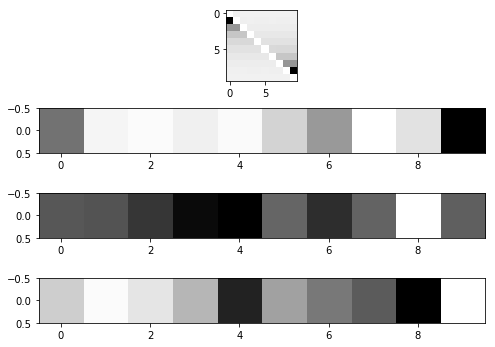

In [10]:
attn = get_attn(X_test[np.newaxis, np.random.randint(len(X_test)), ...], model, disan.attn_dict)
for k, v in attn.items():
    print(k, v.shape)

plot_attn(attn)

In [11]:
y_pred = model.predict(X_test)[:, 0]
y_pred.shape

(205,)

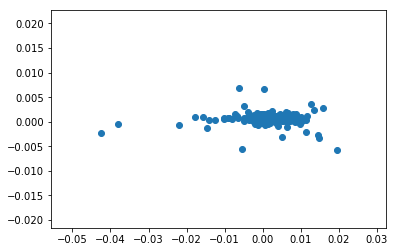

In [12]:
plt.scatter(y_test, y_pred);